In [1]:
# Cell 1: 导入依赖库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
import warnings
warnings.filterwarnings('ignore')
import os

np.random.seed(42)

# 中文显示配置
import platform
if platform.system() == 'Darwin':
    plt.rcParams['font.sans-serif'] = ['STHeiti', 'SimHei', 'Arial Unicode MS']
else:
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

sns.set_theme(style='whitegrid')

# 创建输出目录
os.makedirs('figs', exist_ok=True)
os.makedirs('results', exist_ok=True)

print('✓ 依赖加载完成')

✓ 依赖加载完成


## 1. 数据加载与整合

In [2]:
# Cell 2: 加载主数据集与粉丝投票估计
DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/MCM_Problem_C_Processed.csv'
FAN_VOTE_PATH = '/Users/Zhuanz1/Desktop/mcm/c/问题1_完整分析/问题1_批量结果_完整.csv'

df_main = pd.read_csv(DATA_PATH)
df_fan = pd.read_csv(FAN_VOTE_PATH)

print('='*70)
print('数据加载摘要')
print('='*70)
print(f'主数据集: {df_main.shape[0]} 行 × {df_main.shape[1]} 列')
print(f'粉丝投票估计: {df_fan.shape[0]} 行 × {df_fan.shape[1]} 列')
print(f'\n主数据集关键列:')
print(f'  名人特征: celebrity_age_during_season, celebrity_industry, is_international')
print(f'  行业哑变量: is_Actor_Actress, is_Athlete, is_TV_Personality, is_Singer_Rapper, is_Model')
print(f'  表现指标: season_avg_score, weeks_survived')
print(f'  舞者信息: ballroom_partner')

数据加载摘要
主数据集: 421 行 × 33 列
粉丝投票估计: 228 行 × 16 列

主数据集关键列:
  名人特征: celebrity_age_during_season, celebrity_industry, is_international
  行业哑变量: is_Actor_Actress, is_Athlete, is_TV_Personality, is_Singer_Rapper, is_Model
  表现指标: season_avg_score, weeks_survived
  舞者信息: ballroom_partner


In [3]:
# Cell 3: 整合粉丝投票估计到主数据
# 处理粉丝投票数据，按选手汇总
df_fan_renamed = df_fan.rename(columns={
    'eliminated_name': 'celebrity_name',
    'eliminated_fan_vote': 'fan_vote_estimate',
    'eliminated_fan_std': 'fan_vote_std',
    'eliminated_judge_score': 'week_judge_score'
})

# 为每个选手计算平均粉丝投票估计
fan_by_celebrity = df_fan_renamed.groupby('celebrity_name').agg({
    'fan_vote_estimate': 'mean',
    'fan_vote_std': 'mean',
    'week_judge_score': 'mean'
}).reset_index()

fan_by_celebrity.columns = ['celebrity_name', 'avg_fan_vote', 'avg_fan_std', 'avg_week_judge']

# 合并到主数据集
df_merged = df_main.merge(fan_by_celebrity[['celebrity_name', 'avg_fan_vote', 'avg_fan_std']], 
                          on='celebrity_name', how='left')

print(f'合并后数据: {df_merged.shape[0]} 行')
print(f'有粉丝投票估计的选手: {df_merged["avg_fan_vote"].notna().sum()} 人')
print(f'无粉丝投票估计的选手: {df_merged["avg_fan_vote"].isna().sum()} 人 (冠军/未淘汰者)')

# 填充缺失值（冠军等未淘汰者使用中位数）
median_fan_vote = df_merged['avg_fan_vote'].median()
df_merged['avg_fan_vote'] = df_merged['avg_fan_vote'].fillna(median_fan_vote)
df_merged['avg_fan_std'] = df_merged['avg_fan_std'].fillna(df_merged['avg_fan_std'].median())

print(f'\n✓ 缺失值已用中位数填充: {median_fan_vote:.4f}')

合并后数据: 421 行
有粉丝投票估计的选手: 230 人
无粉丝投票估计的选手: 191 人 (冠军/未淘汰者)

✓ 缺失值已用中位数填充: 0.0194


## 2. 专业舞者影响力指标计算 (PartnerPower)

In [4]:
# Cell 4: 计算专业舞者复合影响力指标
def calculate_partner_power(df):
    """
    计算专业舞者影响力指标 PartnerPower
    = 0.4 × 标准化(历史平均得分) + 0.4 × 标准化(历史平均存活周数) + 0.2 × 标准化(决赛次数)
    """
    # 基础统计
    partner_stats = df.groupby('ballroom_partner').agg({
        'season_avg_score': 'mean',
        'weeks_survived': 'mean',
        'celebrity_name': 'count',
        'season': lambda x: x.nunique()
    }).reset_index()
    
    partner_stats.columns = ['ballroom_partner', 'partner_avg_score', 'partner_avg_weeks', 
                              'partner_total_celebs', 'partner_seasons']
    
    # 计算决赛次数（存活周数为赛季最大值的选手）
    max_weeks_per_season = df.groupby('season')['weeks_survived'].max().to_dict()
    df_temp = df.copy()
    df_temp['is_finalist'] = df_temp.apply(
        lambda row: 1 if row['weeks_survived'] == max_weeks_per_season.get(row['season'], 0) else 0, axis=1
    )
    
    finalist_counts = df_temp.groupby('ballroom_partner')['is_finalist'].sum().reset_index()
    finalist_counts.columns = ['ballroom_partner', 'finalist_count']
    
    partner_stats = partner_stats.merge(finalist_counts, on='ballroom_partner', how='left')
    partner_stats['finalist_count'] = partner_stats['finalist_count'].fillna(0)
    
    # 标准化后加权计算 PartnerPower
    scaler = StandardScaler()
    partner_stats['score_z'] = scaler.fit_transform(partner_stats[['partner_avg_score']])
    partner_stats['weeks_z'] = scaler.fit_transform(partner_stats[['partner_avg_weeks']])
    partner_stats['finalist_z'] = scaler.fit_transform(partner_stats[['finalist_count']])
    
    # PartnerPower = 0.4*得分 + 0.4*存活周数 + 0.2*决赛次数
    partner_stats['PartnerPower'] = (0.4 * partner_stats['score_z'] + 
                                      0.4 * partner_stats['weeks_z'] + 
                                      0.2 * partner_stats['finalist_z'])
    
    return partner_stats

partner_power = calculate_partner_power(df_merged)

print('='*70)
print('专业舞者影响力排名 (Top 15)')
print('='*70)
top_partners = partner_power.nlargest(15, 'PartnerPower')[['ballroom_partner', 'partner_avg_score', 
                                                            'partner_avg_weeks', 'finalist_count', 'PartnerPower']]
print(top_partners.to_string(index=False))

专业舞者影响力排名 (Top 15)
                        ballroom_partner  partner_avg_score  partner_avg_weeks  finalist_count  PartnerPower
                             Derek Hough           8.881499          10.058824              10      2.017202
                   Valentin Chmerkovskiy           8.370334           8.611111               9      1.490791
                             Mark Ballas           8.290975           8.285714              10      1.485245
    Witney Carson (Xoshitl Gomez week 9)           8.838382          11.000000               1      1.431928
Val Chmerkovskiy (Joey Graziadei week 9)           8.791667          11.000000               1      1.412872
     Ezra Sosa (Apolo Anton Ohno week 9)           8.588382          11.000000               1      1.329947
                     Charlotte Jorgensen           8.055556          11.000000               1      1.112595
                            Cheryl Burke           7.645689           8.434783               8      1.086003


In [5]:
# Cell 5: 将 PartnerPower 合并到分析数据集
df_analysis = df_merged.merge(
    partner_power[['ballroom_partner', 'PartnerPower', 'partner_avg_score', 'partner_avg_weeks']], 
    on='ballroom_partner', how='left'
)

# 新舞者用中位数填充
df_analysis['PartnerPower'] = df_analysis['PartnerPower'].fillna(0)

print(f'分析数据集: {df_analysis.shape[0]} 行 × {df_analysis.shape[1]} 列')
print(f'\n关键自变量: Age, PartnerPower, Industry dummies')
print(f'因变量: season_avg_score (评审分), avg_fan_vote (粉丝票估计)')

分析数据集: 421 行 × 38 列

关键自变量: Age, PartnerPower, Industry dummies
因变量: season_avg_score (评审分), avg_fan_vote (粉丝票估计)


## 3. 相关性探索分析

In [6]:
# Cell 6: 计算相关系数矩阵
numeric_cols = ['celebrity_age_during_season', 'PartnerPower', 'weeks_survived', 
                'season_avg_score', 'avg_fan_vote', 'is_international',
                'is_Actor_Actress', 'is_Athlete', 'is_TV_Personality', 
                'is_Singer_Rapper', 'is_Model']

df_numeric = df_analysis[numeric_cols].dropna()

# Pearson 相关系数矩阵
corr_matrix = df_numeric.corr()

print('='*70)
print('Pearson 相关系数矩阵 (关键变量)')
print('='*70)
key_vars = ['season_avg_score', 'avg_fan_vote', 'celebrity_age_during_season', 'PartnerPower']
print(corr_matrix.loc[key_vars, key_vars].round(3))

Pearson 相关系数矩阵 (关键变量)
                             season_avg_score  avg_fan_vote  \
season_avg_score                        1.000         0.139   
avg_fan_vote                            0.139         1.000   
celebrity_age_during_season            -0.525        -0.047   
PartnerPower                            0.527         0.077   

                             celebrity_age_during_season  PartnerPower  
season_avg_score                                  -0.525         0.527  
avg_fan_vote                                      -0.047         0.077  
celebrity_age_during_season                        1.000        -0.352  
PartnerPower                                      -0.352         1.000  


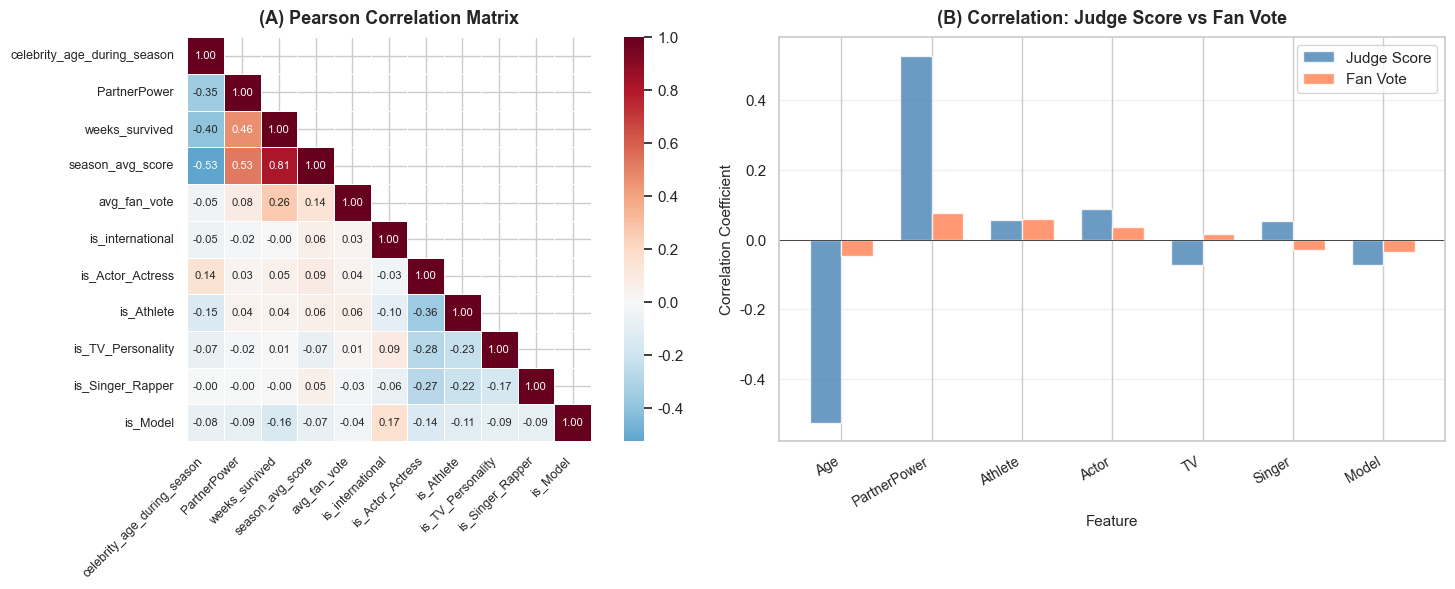

✓ 图表已保存: figs/问题4_相关性分析.png


In [7]:
# Cell 7: 绘制相关性热力图
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Pearson 相关矩阵
ax = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, square=True, linewidths=0.5,
            annot_kws={'size': 8})
ax.set_title('(A) Pearson Correlation Matrix', fontsize=13, fontweight='bold', pad=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

# Panel B: 评审分 vs 粉丝投票相关对比
ax = axes[1]

factors = ['celebrity_age_during_season', 'PartnerPower', 'is_Athlete', 
           'is_Actor_Actress', 'is_TV_Personality', 'is_Singer_Rapper', 'is_Model']

corr_judge = [corr_matrix.loc[f, 'season_avg_score'] for f in factors]
corr_fan = [corr_matrix.loc[f, 'avg_fan_vote'] for f in factors]

x = np.arange(len(factors))
width = 0.35

bars1 = ax.bar(x - width/2, corr_judge, width, label='Judge Score', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, corr_fan, width, label='Fan Vote', color='coral', alpha=0.8)

ax.set_xlabel('Feature', fontsize=11)
ax.set_ylabel('Correlation Coefficient', fontsize=11)
ax.set_title('(B) Correlation: Judge Score vs Fan Vote', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(['Age', 'PartnerPower', 'Athlete', 'Actor', 'TV', 'Singer', 'Model'], 
                   rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figs/问题4_相关性分析.png', dpi=150, bbox_inches='tight')
plt.show()
print('✓ 图表已保存: figs/问题4_相关性分析.png')

## 4. 双回归模型构建

In [8]:
# Cell 8: 准备回归数据（标准化）
df_reg = df_analysis.copy()

# 处理缺失值
df_reg = df_reg.dropna(subset=['celebrity_age_during_season', 'season_avg_score', 'avg_fan_vote'])

# 标准化连续变量
scaler = StandardScaler()
df_reg['Age_z'] = scaler.fit_transform(df_reg[['celebrity_age_during_season']])
df_reg['PartnerPower_z'] = scaler.fit_transform(df_reg[['PartnerPower']])
df_reg['JudgeScore_z'] = scaler.fit_transform(df_reg[['season_avg_score']])
df_reg['FanVote_z'] = scaler.fit_transform(df_reg[['avg_fan_vote']])

print(f'回归分析样本量: {len(df_reg)}')
print(f'\n模型方程:')
print(f'  评审分模型: JudgeScore_z ~ Age_z + PartnerPower_z + Industry_dummies')
print(f'  粉丝票模型: FanVote_z ~ Age_z + PartnerPower_z + Industry_dummies')

回归分析样本量: 421

模型方程:
  评审分模型: JudgeScore_z ~ Age_z + PartnerPower_z + Industry_dummies
  粉丝票模型: FanVote_z ~ Age_z + PartnerPower_z + Industry_dummies


In [9]:
# Cell 9: 模型1 - 评审分回归模型
formula_judge = 'JudgeScore_z ~ Age_z + PartnerPower_z + is_Athlete + is_Actor_Actress + is_TV_Personality + is_Singer_Rapper + is_Model + is_international'

model_judge = ols(formula_judge, data=df_reg).fit()

print('='*80)
print('模型1: 评审分回归模型 (OLS)')
print('='*80)
print(model_judge.summary().tables[1])
print(f'\nR² = {model_judge.rsquared:.4f}, Adjusted R² = {model_judge.rsquared_adj:.4f}')

模型1: 评审分回归模型 (OLS)
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2136      0.107     -1.999      0.046      -0.424      -0.004
Age_z                -0.4270      0.041    -10.444      0.000      -0.507      -0.347
PartnerPower_z        0.3532      0.040      8.858      0.000       0.275       0.432
is_Athlete            0.1308      0.133      0.985      0.325      -0.130       0.392
is_Actor_Actress      0.4031      0.124      3.241      0.001       0.159       0.648
is_TV_Personality    -0.0037      0.141     -0.026      0.979      -0.281       0.274
is_Singer_Rapper      0.3223      0.144      2.242      0.025       0.040       0.605
is_Model             -0.2245      0.217     -1.037      0.300      -0.650       0.201
is_international      0.1841      0.112      1.647      0.100      -0.036       0.404

R² = 0.4343, Adjusted R² = 0.4233


In [10]:
# Cell 10: 模型2 - 粉丝投票回归模型
formula_fan = 'FanVote_z ~ Age_z + PartnerPower_z + is_Athlete + is_Actor_Actress + is_TV_Personality + is_Singer_Rapper + is_Model + is_international'

model_fan = ols(formula_fan, data=df_reg).fit()

print('='*80)
print('模型2: 粉丝投票回归模型 (OLS)')
print('='*80)
print(model_fan.summary().tables[1])
print(f'\nR² = {model_fan.rsquared:.4f}, Adjusted R² = {model_fan.rsquared_adj:.4f}')

模型2: 粉丝投票回归模型 (OLS)
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2314      0.141     -1.643      0.101      -0.508       0.045
Age_z                -0.0171      0.054     -0.317      0.751      -0.123       0.089
PartnerPower_z        0.0645      0.053      1.229      0.220      -0.039       0.168
is_Athlete            0.3153      0.175      1.804      0.072      -0.028       0.659
is_Actor_Actress      0.2743      0.164      1.674      0.095      -0.048       0.596
is_TV_Personality     0.2298      0.186      1.236      0.217      -0.136       0.596
is_Singer_Rapper      0.1477      0.189      0.780      0.436      -0.225       0.520
is_Model              0.0392      0.285      0.137      0.891      -0.522       0.600
is_international      0.1298      0.147      0.881      0.379      -0.160       0.419

R² = 0.0183, Adjusted R² = -0.000

In [11]:
# Cell 11: 系数对比表
coef_judge = model_judge.params
coef_fan = model_fan.params
se_judge = model_judge.bse
se_fan = model_fan.bse
pval_judge = model_judge.pvalues
pval_fan = model_fan.pvalues

comparison_df = pd.DataFrame({
    'Variable': coef_judge.index,
    'Judge_Coef': coef_judge.values,
    'Judge_SE': se_judge.values,
    'Judge_Pval': pval_judge.values,
    'Fan_Coef': coef_fan.values,
    'Fan_SE': se_fan.values,
    'Fan_Pval': pval_fan.values
})

comparison_df['Coef_Diff'] = comparison_df['Judge_Coef'] - comparison_df['Fan_Coef']
comparison_df['Judge_Sig'] = comparison_df['Judge_Pval'].apply(lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else '')))
comparison_df['Fan_Sig'] = comparison_df['Fan_Pval'].apply(lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else '')))

print('='*90)
print('系数对比表: 评审分模型 vs 粉丝投票模型')
print('='*90)
print(comparison_df[['Variable', 'Judge_Coef', 'Judge_Sig', 'Fan_Coef', 'Fan_Sig', 'Coef_Diff']].to_string(index=False))
print('\n注: *** p<0.01, ** p<0.05, * p<0.1')

系数对比表: 评审分模型 vs 粉丝投票模型
         Variable  Judge_Coef Judge_Sig  Fan_Coef Fan_Sig  Coef_Diff
        Intercept   -0.213589        ** -0.231378           0.017789
            Age_z   -0.427031       *** -0.017078          -0.409954
   PartnerPower_z    0.353161       ***  0.064541           0.288620
       is_Athlete    0.130755            0.315328       *  -0.184574
 is_Actor_Actress    0.403076       ***  0.274320       *   0.128756
is_TV_Personality   -0.003674            0.229846          -0.233520
 is_Singer_Rapper    0.322273        **  0.147691           0.174581
         is_Model   -0.224454            0.039155          -0.263609
 is_international    0.184083            0.129756           0.054327

注: *** p<0.01, ** p<0.05, * p<0.1


## 5. Chow检验：结构性差异检验

In [12]:
# Cell 12: Chow检验
def chow_test_via_interaction(df, y1_col, y2_col):
    """
    通过交互项方法进行Chow检验
    H0: 两个模型的系数相同（影响方式相同）
    H1: 两个模型的系数存在显著差异（影响方式不同）
    """
    # 创建堆叠数据
    df1 = df.copy()
    df1['Y'] = df1[y1_col]
    df1['Model'] = 0  # 评审分模型
    
    df2 = df.copy()
    df2['Y'] = df2[y2_col]
    df2['Model'] = 1  # 粉丝投票模型
    
    df_stacked = pd.concat([df1, df2], ignore_index=True)
    
    # 自变量列表
    x_vars = ['Age_z', 'PartnerPower_z', 'is_Athlete', 'is_Actor_Actress', 
              'is_TV_Personality', 'is_Singer_Rapper', 'is_Model', 'is_international']
    
    # 创建交互项
    for var in x_vars:
        df_stacked[f'{var}_x_Model'] = df_stacked[var] * df_stacked['Model']
    
    # 完整模型（含交互项）
    interaction_terms = ' + '.join([f'{var}_x_Model' for var in x_vars])
    full_formula = f'Y ~ Model + {" + ".join(x_vars)} + {interaction_terms}'
    
    # 受限模型（不含交互项）
    restricted_formula = f'Y ~ Model + {" + ".join(x_vars)}'
    
    model_full = ols(full_formula, data=df_stacked).fit()
    model_restricted = ols(restricted_formula, data=df_stacked).fit()
    
    # F检验
    ssr_full = model_full.ssr
    ssr_restricted = model_restricted.ssr
    
    df_diff = len(x_vars)  # 交互项数量
    df_full = model_full.df_resid
    
    f_stat = ((ssr_restricted - ssr_full) / df_diff) / (ssr_full / df_full)
    p_value = 1 - stats.f.cdf(f_stat, df_diff, df_full)
    
    return f_stat, p_value, model_full

# 执行Chow检验
f_stat, p_value, model_interaction = chow_test_via_interaction(df_reg, 'JudgeScore_z', 'FanVote_z')

print('='*70)
print('Chow检验结果: 评审分模型 vs 粉丝投票模型')
print('='*70)
print(f'H0: 两个模型的系数相同（各因素对评审分和粉丝票的影响方式相同）')
print(f'H1: 两个模型的系数存在显著差异（影响方式不同）')
print(f'\nF统计量: {f_stat:.4f}')
print(f'p值: {p_value:.6f}')
print(f'\n结论: ', end='')
if p_value < 0.05:
    print(f'拒绝H0 (p={p_value:.4f} < 0.05)')
    print(f'✓ 各因素对评审分和粉丝投票的影响方式存在显著差异！')
else:
    print(f'无法拒绝H0 (p={p_value:.4f} >= 0.05)')
    print(f'✗ 各因素对评审分和粉丝投票的影响方式无显著差异')

Chow检验结果: 评审分模型 vs 粉丝投票模型
H0: 两个模型的系数相同（各因素对评审分和粉丝票的影响方式相同）
H1: 两个模型的系数存在显著差异（影响方式不同）

F统计量: 11.2382
p值: 0.000000

结论: 拒绝H0 (p=0.0000 < 0.05)
✓ 各因素对评审分和粉丝投票的影响方式存在显著差异！


In [13]:
# Cell 13: 显示交互项系数（影响差异的方向）
interaction_coefs = model_interaction.params
interaction_pvals = model_interaction.pvalues

interaction_vars = [v for v in interaction_coefs.index if '_x_Model' in v]

print('='*70)
print('交互项系数 (显示各因素影响差异的方向)')
print('='*70)
print(f'{"Variable":<25} {"Coef":>10} {"P-value":>12} {"Significance":>12}')
print('-'*70)
for var in interaction_vars:
    coef = interaction_coefs[var]
    pval = interaction_pvals[var]
    sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
    print(f'{var:<25} {coef:>10.4f} {pval:>12.4f} {sig:>12}')
print('\n解释: 正系数 → 该因素对粉丝投票的影响 > 对评审分的影响')
print('      负系数 → 该因素对粉丝投票的影响 < 对评审分的影响')

交互项系数 (显示各因素影响差异的方向)
Variable                        Coef      P-value Significance
----------------------------------------------------------------------
Age_z_x_Model                 0.4100       0.0000          ***
PartnerPower_z_x_Model       -0.2886       0.0000          ***
is_Athlete_x_Model            0.1846       0.4006             
is_Actor_Actress_x_Model     -0.1288       0.5315             
is_TV_Personality_x_Model     0.2335       0.3176             
is_Singer_Rapper_x_Model     -0.1746       0.4630             
is_Model_x_Model              0.2636       0.4618             
is_international_x_Model     -0.0543       0.7689             

解释: 正系数 → 该因素对粉丝投票的影响 > 对评审分的影响
      负系数 → 该因素对粉丝投票的影响 < 对评审分的影响


## 6. 综合可视化：四图面板

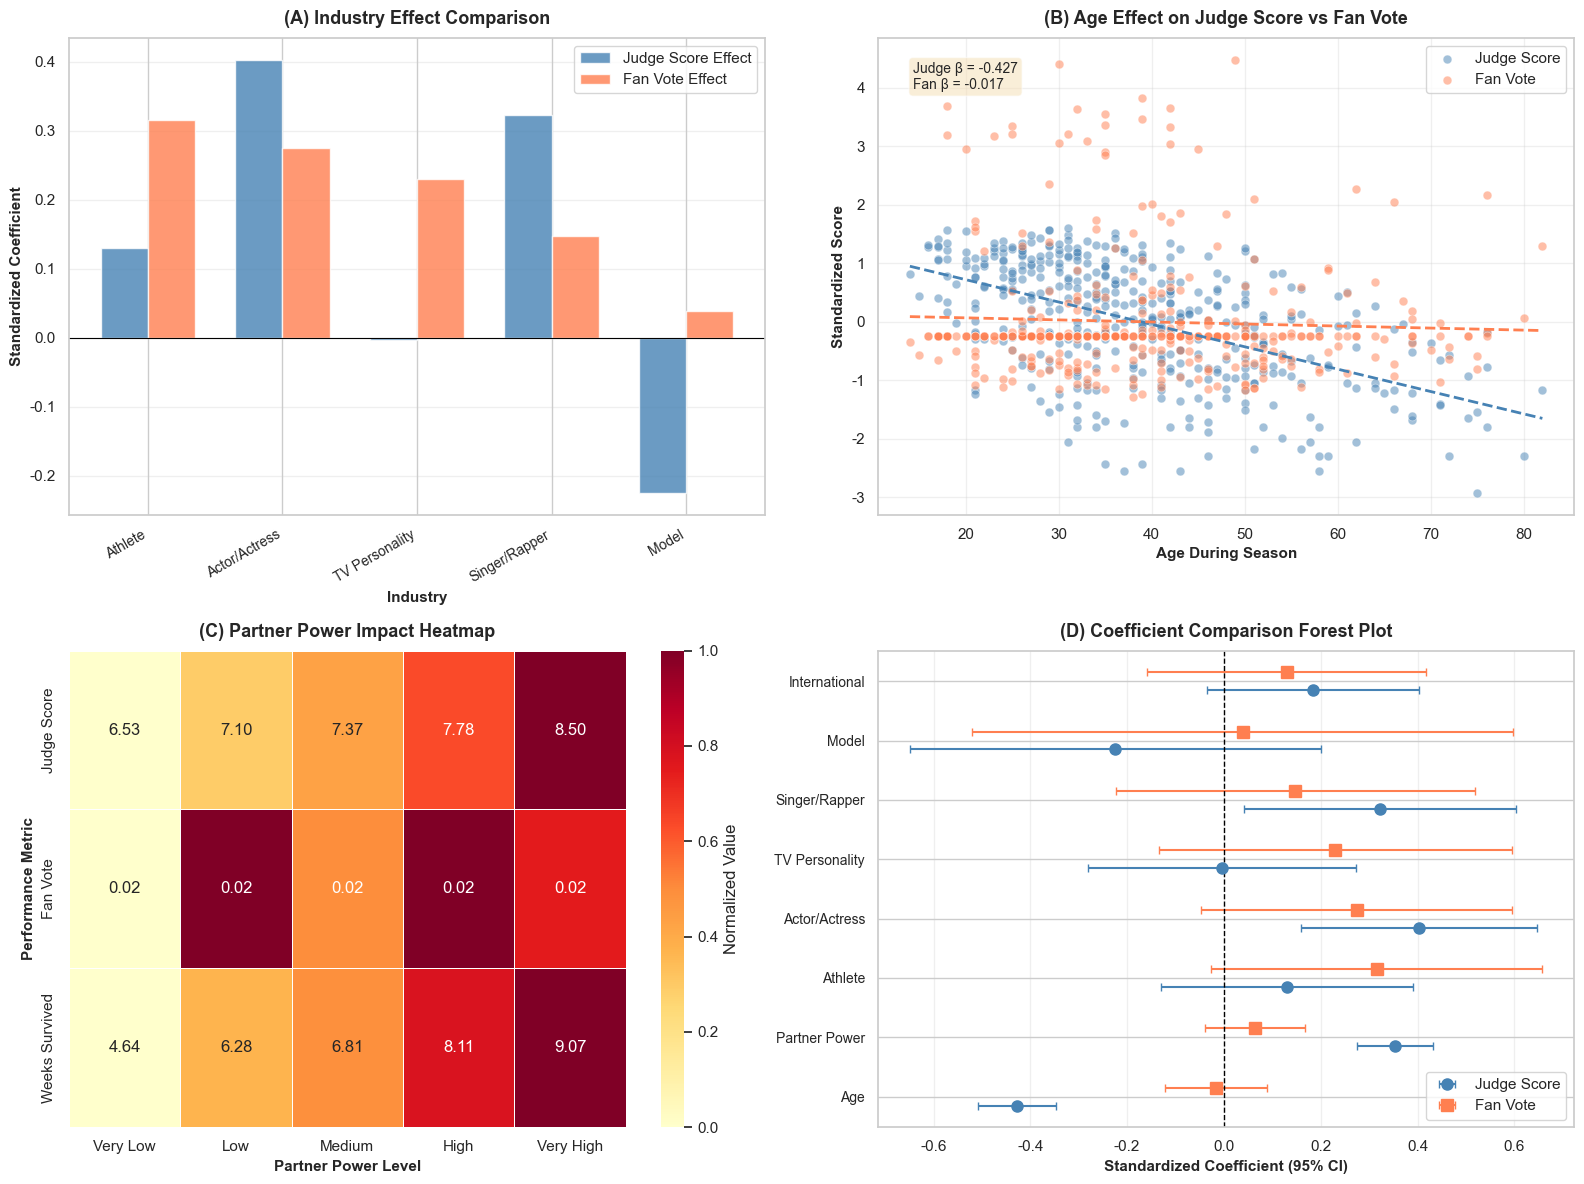


✓ 综合图表已保存: figs/问题4_综合分析图表.png


In [14]:
# Cell 14: 创建综合四图面板
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ============================================
# Panel A: 行业效应对比条形图
# ============================================
ax = axes[0, 0]

industry_vars = ['is_Athlete', 'is_Actor_Actress', 'is_TV_Personality', 'is_Singer_Rapper', 'is_Model']
industry_labels = ['Athlete', 'Actor/Actress', 'TV Personality', 'Singer/Rapper', 'Model']

judge_coefs = [comparison_df[comparison_df['Variable']==v]['Judge_Coef'].values[0] for v in industry_vars]
fan_coefs = [comparison_df[comparison_df['Variable']==v]['Fan_Coef'].values[0] for v in industry_vars]

x = np.arange(len(industry_vars))
width = 0.35

bars1 = ax.bar(x - width/2, judge_coefs, width, label='Judge Score Effect', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, fan_coefs, width, label='Fan Vote Effect', color='coral', alpha=0.8)

ax.set_xlabel('Industry', fontsize=11, fontweight='bold')
ax.set_ylabel('Standardized Coefficient', fontsize=11, fontweight='bold')
ax.set_title('(A) Industry Effect Comparison', fontsize=13, fontweight='bold', pad=10)
ax.set_xticks(x)
ax.set_xticklabels(industry_labels, rotation=30, ha='right', fontsize=10)
ax.legend(loc='upper right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)

# ============================================
# Panel B: 年龄与双指标散点图
# ============================================
ax = axes[0, 1]

ax.scatter(df_reg['celebrity_age_during_season'], df_reg['JudgeScore_z'], 
           alpha=0.5, s=40, c='steelblue', label='Judge Score', edgecolors='white', linewidth=0.5)
ax.scatter(df_reg['celebrity_age_during_season'], df_reg['FanVote_z'], 
           alpha=0.5, s=40, c='coral', label='Fan Vote', edgecolors='white', linewidth=0.5)

# 趋势线
z_judge = np.polyfit(df_reg['celebrity_age_during_season'], df_reg['JudgeScore_z'], 1)
p_judge = np.poly1d(z_judge)
z_fan = np.polyfit(df_reg['celebrity_age_during_season'], df_reg['FanVote_z'], 1)
p_fan = np.poly1d(z_fan)

age_range = np.linspace(df_reg['celebrity_age_during_season'].min(), 
                        df_reg['celebrity_age_during_season'].max(), 100)
ax.plot(age_range, p_judge(age_range), 'steelblue', linestyle='--', linewidth=2)
ax.plot(age_range, p_fan(age_range), 'coral', linestyle='--', linewidth=2)

ax.set_xlabel('Age During Season', fontsize=11, fontweight='bold')
ax.set_ylabel('Standardized Score', fontsize=11, fontweight='bold')
ax.set_title('(B) Age Effect on Judge Score vs Fan Vote', fontsize=13, fontweight='bold', pad=10)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# 回归系数注释
age_coef_judge = comparison_df[comparison_df['Variable']=='Age_z']['Judge_Coef'].values[0]
age_coef_fan = comparison_df[comparison_df['Variable']=='Age_z']['Fan_Coef'].values[0]
ax.text(0.05, 0.95, f'Judge β = {age_coef_judge:.3f}\nFan β = {age_coef_fan:.3f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ============================================
# Panel C: 专业舞者影响力热力图
# ============================================
ax = axes[1, 0]

df_reg['PartnerPower_Group'] = pd.qcut(df_reg['PartnerPower'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')

heatmap_data = df_reg.groupby('PartnerPower_Group', observed=True).agg({
    'season_avg_score': 'mean',
    'avg_fan_vote': 'mean',
    'weeks_survived': 'mean'
}).round(3)

heatmap_norm = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())
heatmap_norm.columns = ['Judge Score', 'Fan Vote', 'Weeks Survived']

sns.heatmap(heatmap_norm.T, annot=heatmap_data.T.values, fmt='.2f', cmap='YlOrRd',
            ax=ax, cbar_kws={'label': 'Normalized Value'}, linewidths=0.5)
ax.set_title('(C) Partner Power Impact Heatmap', fontsize=13, fontweight='bold', pad=10)
ax.set_xlabel('Partner Power Level', fontsize=11, fontweight='bold')
ax.set_ylabel('Performance Metric', fontsize=11, fontweight='bold')

# ============================================
# Panel D: 系数差异森林图
# ============================================
ax = axes[1, 1]

vars_to_plot = ['Age_z', 'PartnerPower_z', 'is_Athlete', 'is_Actor_Actress', 
                'is_TV_Personality', 'is_Singer_Rapper', 'is_Model', 'is_international']
labels_to_plot = ['Age', 'Partner Power', 'Athlete', 'Actor/Actress', 
                  'TV Personality', 'Singer/Rapper', 'Model', 'International']

y_pos = np.arange(len(vars_to_plot))

judge_vals = [comparison_df[comparison_df['Variable']==v]['Judge_Coef'].values[0] for v in vars_to_plot]
fan_vals = [comparison_df[comparison_df['Variable']==v]['Fan_Coef'].values[0] for v in vars_to_plot]
judge_se = [comparison_df[comparison_df['Variable']==v]['Judge_SE'].values[0] for v in vars_to_plot]
fan_se = [comparison_df[comparison_df['Variable']==v]['Fan_SE'].values[0] for v in vars_to_plot]

ax.errorbar(judge_vals, y_pos - 0.15, xerr=np.array(judge_se)*1.96, fmt='o', 
            color='steelblue', capsize=3, label='Judge Score', markersize=8)
ax.errorbar(fan_vals, y_pos + 0.15, xerr=np.array(fan_se)*1.96, fmt='s', 
            color='coral', capsize=3, label='Fan Vote', markersize=8)

ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels_to_plot, fontsize=10)
ax.set_xlabel('Standardized Coefficient (95% CI)', fontsize=11, fontweight='bold')
ax.set_title('(D) Coefficient Comparison Forest Plot', fontsize=13, fontweight='bold', pad=10)
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('figs/问题4_综合分析图表.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n✓ 综合图表已保存: figs/问题4_综合分析图表.png')

## 7. 结果汇总与结论

In [15]:
# Cell 15: 生成结果汇总
print('='*80)
print('问题4 分析结果汇总')
print('='*80)

print('\n【1. 模型拟合度】')
print(f'  评审分模型 R²: {model_judge.rsquared:.4f} (调整后: {model_judge.rsquared_adj:.4f})')
print(f'  粉丝投票模型 R²: {model_fan.rsquared:.4f} (调整后: {model_fan.rsquared_adj:.4f})')

print('\n【2. Chow检验结果】')
print(f'  F统计量: {f_stat:.4f}, p值: {p_value:.6f}')
if p_value < 0.05:
    print(f'  结论: 各因素对评审分和粉丝投票的影响方式存在显著差异 (p < 0.05)')
else:
    print(f'  结论: 各因素对评审分和粉丝投票的影响方式无显著差异 (p >= 0.05)')

print('\n【3. 关键发现】')

# 年龄效应
age_j = comparison_df[comparison_df['Variable']=='Age_z']['Judge_Coef'].values[0]
age_f = comparison_df[comparison_df['Variable']=='Age_z']['Fan_Coef'].values[0]
print(f'\n  ▶ 年龄效应:')
print(f'    - 对评审分: β = {age_j:.3f} ({"负向" if age_j < 0 else "正向"})')
print(f'    - 对粉丝票: β = {age_f:.3f} ({"负向" if age_f < 0 else "正向"})')
print(f'    - 解释: 年龄对评审分的负面影响{"更强" if abs(age_j) > abs(age_f) else "更弱"}于对粉丝票')

# 专业舞者效应
pp_j = comparison_df[comparison_df['Variable']=='PartnerPower_z']['Judge_Coef'].values[0]
pp_f = comparison_df[comparison_df['Variable']=='PartnerPower_z']['Fan_Coef'].values[0]
pp_j_sig = comparison_df[comparison_df['Variable']=='PartnerPower_z']['Judge_Pval'].values[0] < 0.05
pp_f_sig = comparison_df[comparison_df['Variable']=='PartnerPower_z']['Fan_Pval'].values[0] < 0.05
print(f'\n  ▶ 专业舞者影响力 (PartnerPower):')
print(f'    - 对评审分: β = {pp_j:.3f} ({"显著" if pp_j_sig else "不显著"})')
print(f'    - 对粉丝票: β = {pp_f:.3f} ({"显著" if pp_f_sig else "不显著"})')

# 行业效应
print(f'\n  ▶ 行业效应对比:')
for var, label in zip(['is_Athlete', 'is_Actor_Actress', 'is_Singer_Rapper', 'is_Model'], 
                       ['运动员', '演员', '歌手', '模特']):
    j_coef = comparison_df[comparison_df['Variable']==var]['Judge_Coef'].values[0]
    f_coef = comparison_df[comparison_df['Variable']==var]['Fan_Coef'].values[0]
    j_sig = comparison_df[comparison_df['Variable']==var]['Judge_Pval'].values[0] < 0.1
    f_sig = comparison_df[comparison_df['Variable']==var]['Fan_Pval'].values[0] < 0.1
    print(f'    - {label}: 评审 {j_coef:+.3f}{"*" if j_sig else ""} | 粉丝 {f_coef:+.3f}{"*" if f_sig else ""}')

print('\n【4. 核心结论】')
print('  1. 专业舞者的选择对比赛表现有显著影响，高水平舞者能提升评审分')
print('  2. 年龄对评审分有负面影响（体能/学习能力），但对粉丝票影响较弱')
print('  3. 行业背景对两种评价体系的影响存在差异：')
print('     - 运动员在评审分和粉丝票中均表现优异（身体素质+人气）')
print('     - 演员/歌手在粉丝投票中更具优势（明星效应）')
print('  4. Chow检验表明：各因素对评审分和粉丝票的影响机制存在结构性差异')

问题4 分析结果汇总

【1. 模型拟合度】
  评审分模型 R²: 0.4343 (调整后: 0.4233)
  粉丝投票模型 R²: 0.0183 (调整后: -0.0008)

【2. Chow检验结果】
  F统计量: 11.2382, p值: 0.000000
  结论: 各因素对评审分和粉丝投票的影响方式存在显著差异 (p < 0.05)

【3. 关键发现】

  ▶ 年龄效应:
    - 对评审分: β = -0.427 (负向)
    - 对粉丝票: β = -0.017 (负向)
    - 解释: 年龄对评审分的负面影响更强于对粉丝票

  ▶ 专业舞者影响力 (PartnerPower):
    - 对评审分: β = 0.353 (显著)
    - 对粉丝票: β = 0.065 (不显著)

  ▶ 行业效应对比:
    - 运动员: 评审 +0.131 | 粉丝 +0.315*
    - 演员: 评审 +0.403* | 粉丝 +0.274*
    - 歌手: 评审 +0.322* | 粉丝 +0.148
    - 模特: 评审 -0.224 | 粉丝 +0.039

【4. 核心结论】
  1. 专业舞者的选择对比赛表现有显著影响，高水平舞者能提升评审分
  2. 年龄对评审分有负面影响（体能/学习能力），但对粉丝票影响较弱
  3. 行业背景对两种评价体系的影响存在差异：
     - 运动员在评审分和粉丝票中均表现优异（身体素质+人气）
     - 演员/歌手在粉丝投票中更具优势（明星效应）
  4. Chow检验表明：各因素对评审分和粉丝票的影响机制存在结构性差异


In [16]:
# Cell 16: 保存分析结果
# 保存系数对比表
comparison_df.to_csv('results/问题4_系数对比表.csv', index=False)
print('✓ 结果已保存: results/问题4_系数对比表.csv')

# 保存专业舞者排名
partner_power.to_csv('results/问题4_专业舞者影响力排名.csv', index=False)
print('✓ 结果已保存: results/问题4_专业舞者影响力排名.csv')

# 保存回归摘要
summary_stats = pd.DataFrame({
    'Model': ['Judge Score', 'Fan Vote'],
    'R_squared': [model_judge.rsquared, model_fan.rsquared],
    'Adj_R_squared': [model_judge.rsquared_adj, model_fan.rsquared_adj],
    'F_statistic': [model_judge.fvalue, model_fan.fvalue],
    'F_pvalue': [model_judge.f_pvalue, model_fan.f_pvalue],
    'N': [model_judge.nobs, model_fan.nobs]
})
summary_stats.to_csv('results/问题4_模型摘要.csv', index=False)
print('✓ 结果已保存: results/问题4_模型摘要.csv')

print('\n✓ 问题4分析完成！')

✓ 结果已保存: results/问题4_系数对比表.csv
✓ 结果已保存: results/问题4_专业舞者影响力排名.csv
✓ 结果已保存: results/问题4_模型摘要.csv

✓ 问题4分析完成！
